In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.Max_columns', None)
import torch.utils as utils
import torch
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
from itertools import chain
from IPython.display import clear_output
import re
import string
import torch.nn.functional as F
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('/content/drive/MyDrive/ML_final_project/mixology_cocktails.json') as f:
    d = json.load(f)
df = pd.DataFrame.from_dict(d).T.reset_index(drop=True)#.drop(['name', 'similar', 'notes'], axis=1)

# Preprocessing

In [4]:
cocktails = df.copy()
cocktails['ing_ml'] = cocktails['ingredients'].apply(lambda x: [int(i['ml']) for i in x])
cocktails = cocktails[cocktails['ing_ml'].apply(sum)<=1000]

In [5]:
cocktails['full_text'] = cocktails['ingredients'].apply(lambda x: ', '.join([x[i]['text'] + ' ' + str(int(x[i]['ml'])) for i in range(len(x))]))
cocktails['name_ingr'] = cocktails['name'] + ' : ' + cocktails['full_text']
df = cocktails[['name','name_ingr']]

In [6]:
df['name'] = df['name'].str.replace('.', '')
df['name'] = df['name'].apply(lambda x: x.lower().strip() + '.')

In [7]:
# df['name'] = df['name'].str.replace(' ', '')

In [8]:
df['name'] = df['name'].str.replace('[^\dA-Za-z ,:]', '')

In [9]:
# df['name'] = df['name'].str.replace(',', '')

In [10]:
chars = "." + string.ascii_lowercase + '1234567890 ' + ',#@$%^&*()_'
num_chars = len(chars)

In [11]:
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {v:k for k, v in char_to_id.items()}

In [12]:
df['name'].str.len().mean()

14.81077745783628

In [13]:
max_length = 20

In [14]:
class CocktailsDataset(Dataset):
    
    def __init__(self, names_list):
        self.names_list = names_list
        
    def __len__(self):
        return len(self.names_list)
    
    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length]
        # print(x_str)
        y_str = x_str[1:] + "."
        
        x = torch.zeros((max_length, num_chars))
        y = torch.zeros(max_length)
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]
        return x, y


In [15]:
train, test = df['name'].tolist()[:-800], df['name'].tolist()[-800:]

In [16]:
trainset = CocktailsDataset(train)
valset = CocktailsDataset(train)

In [17]:
train_batch_size = 128

In [18]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=train_batch_size, shuffle=True)

In [19]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
print(X.size(), Y.size())

torch.Size([128, 20, 49]) torch.Size([128, 20])


In [20]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [21]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.lstm1 = nn.LSTM(49, 64, num_layers=1, batch_first=True)
        self.fc2 = nn.Linear(64, 49)
        self.fc3 = nn.Linear(49, 49)
        
    def forward(self, X, states):
        ht, ct = states
        out, (ht, ct) = self.lstm1(X, (ht, ct))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (ht, ct) 

In [22]:
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

In [23]:
lr = 3e-4

In [24]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [25]:
def generate(model, name_to_find):
    model.eval()
    with torch.no_grad():
        ht = torch.zeros((1, 1, 64))
        ht = ht.to(device)
        ct = torch.zeros((1, 1, 64))
        ct = ct.to(device)
        cur_len = 0
        cur_name = name_to_find
        for char in name_to_find:
            X = torch.zeros((1, 1, num_chars)).to(device)
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            cur_len += 1
        vals, idxs = torch.topk(out[0], 5)
        idx = np.random.choice(idxs.cpu().numpy()[0])
        char = id_to_char[idx]

        while char != "." and cur_len <= max_length-1:
            X = torch.zeros((1, 1, num_chars)).to(device)
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            vals, idxs = torch.topk(out[0], 5) 
            idx = np.random.choice(idxs.cpu().numpy()[0])
            char = id_to_char[idx]
            cur_len += 1
            cur_name += char
    
        if cur_name[-1] != ".":
            cur_name += "."
    

    
    return cur_name

In [26]:
epochs = 100

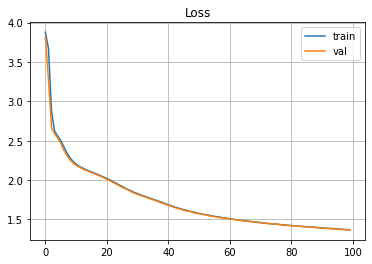

In [27]:
train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    train_loss = 0
    val_loss = 0
    model.train()
    for (X, Y) in tqdm(train_loader):
        X, Y = X.to(device), Y.to(device)
        ht = torch.zeros((1, X.size(0), 64)).to(device)
        ct = torch.zeros((1, X.size(0), 64)).to(device)

        
        pred, (ht, ct) = model(X, (ht, ct))
        pred = pred.transpose(1, 2)
        loss = criterion(pred, Y.long())
        loss.backward()
        optimizer.step()
        model.zero_grad()
        
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        for (X, Y) in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            ht = torch.zeros((1, X.size(0), 64)).to(device)
            ct = torch.zeros((1, X.size(0), 64)).to(device)

            pred, (ht, ct) = model(X, (ht, ct))
            pred = pred.transpose(1, 2)
            loss = criterion(pred, Y.long())
            val_loss += loss.item()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    clear_output()
    plt.title('Loss')
    plt.plot(train_losses, label = 'train')
    plt.plot(val_losses, label ='val')
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
start_names = ['shrek', 'rshb', 'sberbank', 'samsung', 'vodka', 'beer', 'jin', 'long', 'moscow', 'whiskey']
gens = {}
for name in start_names:
    k = 5
    count = 0
    gens[name] = []
    while count <= k:
        generated = generate(model, name)
        gens[name].append(generated)
        count += 1

for g in gens:
    print(f'generated from {g} : \n {gens[g]} ')


generated from shrek : 
 ['shrek pindi.', 'shrekn dateel punge .', 'shreke valaik cuoche.', 'shreka.', 'shrek.', 'shreky curcosta.'] 
generated from rshb : 
 ['rshbthel pencha.', 'rshba sen frizlonste.', 'rshblin.', 'rshbatalis.', 'rshbns.', 'rshbndar.'] 
generated from sberbank : 
 ['sberbank.', 'sberbank.', 'sberbank.', 'sberbankinent.', 'sberbankernarian.', 'sberbankcoollal fil.'] 
generated from samsung : 
 ['samsung.', 'samsungllio fopilana.', 'samsung.', 'samsunga panetil.', 'samsungns vilterern .', 'samsunglli furiorto.'] 
generated from vodka : 
 ['vodkae.', 'vodkaent fund pepl.', 'vodka sonchetre.', 'vodkaina pacortati n.', 'vodkaiate fratherner.', 'vodkati fig.'] 
generated from beer : 
 ['beer brodis.', 'beerat meria.', 'beeryy.', 'beerales cles seriot.', 'beerat sigel pizli v.', 'beerar bor pocle.'] 
generated from jin : 
 ['jinaterisen.', 'jinliosh.', 'jinra bonsaness.', 'jinnan.', 'jinne matail papioti.', 'jinn bateene finge.'] 
generated from long : 
 ['longmumin priacar